In [ ]:
import os
import numpy as np
from imageio.v3 import imread
from scipy import linalg as la
from matplotlib import pyplot as plt

## Helper Functions (NOT CODED BY ME ****)

In [2]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:] == "jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, mode='F')))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:] == "jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, mode='F'))

In [3]:
# Implement show()
# Use show() to display a face from the `faces94` dataset.

def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    # Convert flattened image to its original shape
    og_image = np.reshape(image, (m, n))

    # Plot the original image
    plt.imshow(og_image, cmap="gray")
    plt.axis('off')
    
    plt.show()

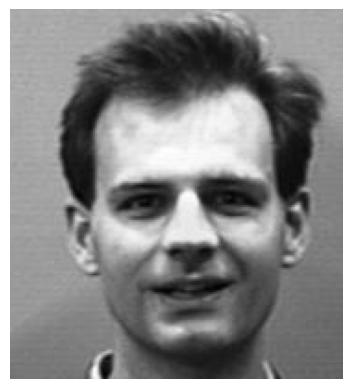

In [4]:
F = get_faces()
show(F[:, 1])

In [5]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        # Construct F, (the flattened image) and store it as attribute
        F = get_faces()
        self.F = F

        # Compute the mean face and store as attribute
        self.mu = np.mean(self.F, axis=1)

        # Compute shifted mean face and store as attribute
        self.F_bar = self.F - self.mu.reshape(-1, 1)

        # Calculate compact SVD of F_bar
        U, Sigma, Vh = np.linalg.svd(self.F_bar, full_matrices = False)

        # Save matrix U as an attribute
        self.U = U
        
   
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        # Calculate the projection of input matrix/ vector
        return (self.U[:, :s]).T @ A 
        
   
    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        # Shift g by the mean to obtain g bar
        g_bar = g - self.mu

        # Compute F hat and g hat, the projections of each onto the first s eigenfaces
        F_hat = self.project(self.F_bar, s)
        g_hat = self.project(g_bar, s)

        # Determine j, the best matching face in the database
        fihat_gihat_distances = np.linalg.norm(F_hat - g_hat[:, np.newaxis], axis=0)
        j = np.argmin(fihat_gihat_distances)

        return j

  
    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        # Find the index j of the best matching face
        best_index = self.find_nearest(image, s)

        # Use the index to find the best matching image
        best_image = self.F[:, best_index]

        # Repeat steps done in show function, to plot original face g along side the best match fj
        # Convert flattened images to their original shapes
        og_image_reshaped = np.reshape(image, (m,n))
        matching_image_reshaped = np.reshape(best_image, (m,n))

        plt.figure()

        # Plot the original image
        plt.subplot(1, 2, 1)
        plt.imshow(og_image_reshaped, cmap ='gray')
        plt.axis('off')
        plt.title("Original image")
        
        # Plot the best matched image
        plt.subplot(1, 2, 2)
        plt.imshow(matching_image_reshaped, cmap ='gray')
        plt.axis('off')
        plt.title("Best matched image")

        plt.show()

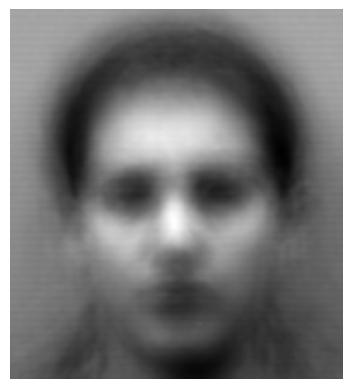

In [6]:
""" In `FacialRec.__init__()`, compute $F$, the mean face $\boldsymbol{\mu}$, and the mean-shifted faces $\bar{F}$.
    Store each as an attribute.
    Initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face. """"

# Show mean face
face = FacialRec()
mean_face = face.mu
show(mean_face)

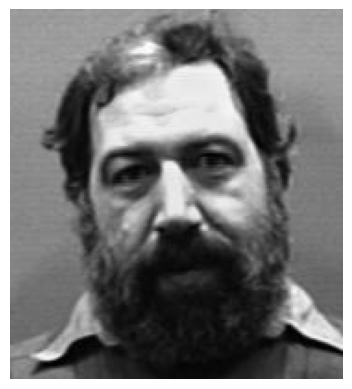

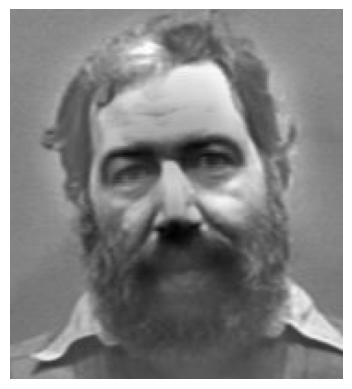

In [7]:
# Show original face, and shifted face of that face
faces = FacialRec()
og_face = face.F[:, 2]
shifted_face = face.F_bar[:, 2]

show(og_face)
show(shifted_face)

1st Eigenface:


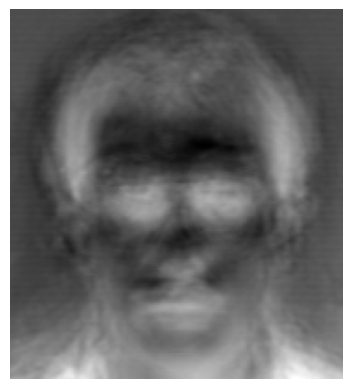

50th Eigenface:


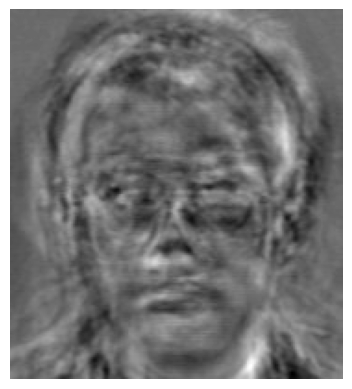

100th Eigenface:


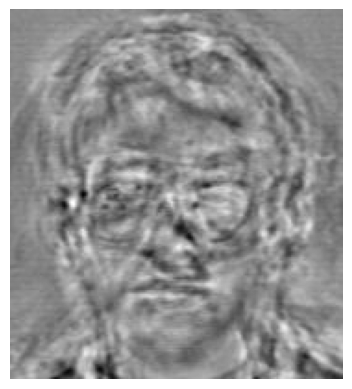

In [8]:
""" In `FacialRec.__init__()`, compute the compact SVD of $\bar{F}$ and store the $U$ as an attribute.
    Use `show()` to display some of the eigenfaces (the columns of $U$).
    Implement `FacialRec.project()` (in a single line)."""


# Display different computed eigenfaces
print("1st Eigenface:")
show(faces.U[:, 0])

print("50th Eigenface:")
show(faces.U[:, 49])

print("100th Eigenface:")
show(faces.U[:, 99])

Image of reconstruction with 5 eigenfaces


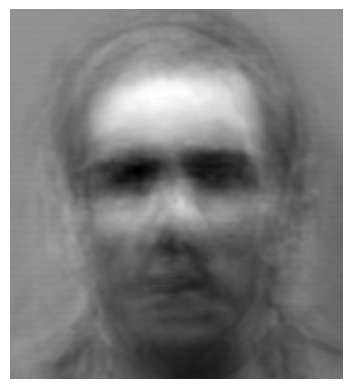

Image of reconstruction with 19 eigenfaces


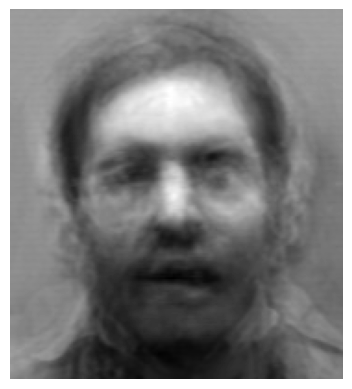

Image of reconstruction with 75 eigenfaces


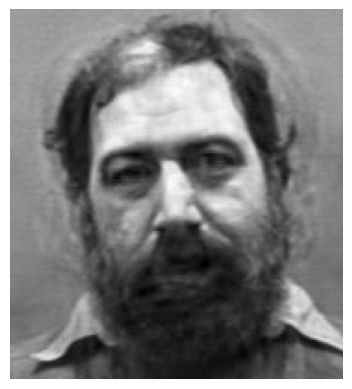

Image of reconstruction with 200 eigenfaces


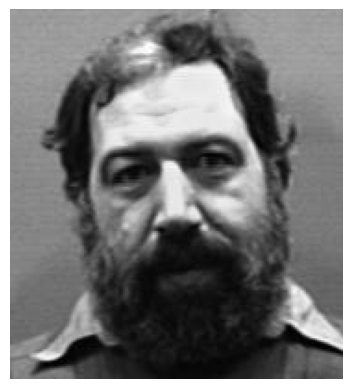

The original image


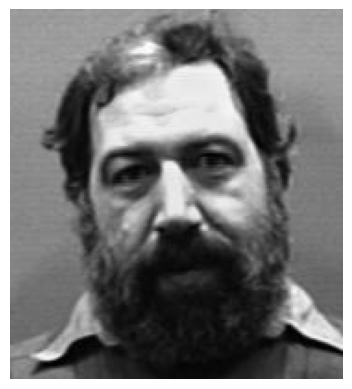

In [9]:
""" - Select one of the shifted images $\bar{\mathbf{f}}_i$.
- For at least 4 values of $s$, use `FacialRec.project()` to compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$, then compute the reconstruction $\widetilde{\mathbf{f}}_i$.
- Display each of the reconstructions and the original image. """

# Already initalized object in earlier cell 

# Get projections with given s numbers of eigenfaces
s1, s2, s3, s4 = 5, 19, 75, 200

# Compute corresponding s projections
projection1 = faces.project(faces.F_bar[:, 2], s1)
projection2 = faces.project(faces.F_bar[:, 2], s2)
projection3 = faces.project(faces.F_bar[:, 2], s3)
projection4 = faces.project(faces.F_bar[:, 2], s4)

# Compute the reconstruction of each s-projection
reconstructed1 = faces.U[:, :s1] @ projection1 + faces.mu
reconstructed2 = faces.U[:, :s2] @ projection2 + faces.mu
reconstructed3 = faces.U[:, :s3] @ projection3 + faces.mu
reconstructed4 = faces.U[:, :s4] @ projection4 + faces.mu

# Display the various reconstructions
print("Image of reconstruction with 5 eigenfaces")
show(reconstructed1)
print("Image of reconstruction with 19 eigenfaces")
show(reconstructed2)
print("Image of reconstruction with 75 eigenfaces")
show(reconstructed3)
print("Image of reconstruction with 200 eigenfaces")
show(reconstructed4)

# Display original image
print("The original image")
show(faces.F[:, 2])


## Problem 6

- Implement `FacialRec.match()`.
- Generate some random faces with `sample_faces()`, and use `FacialRec.match()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match.

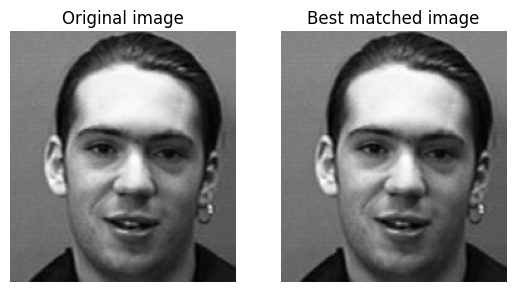

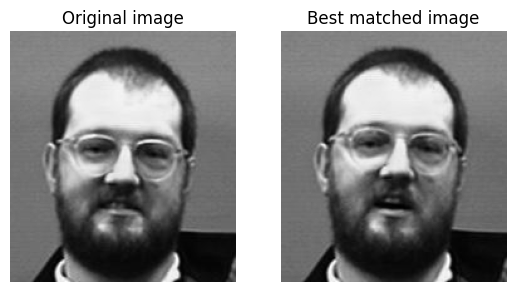

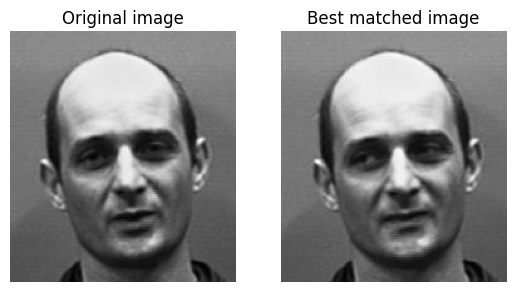

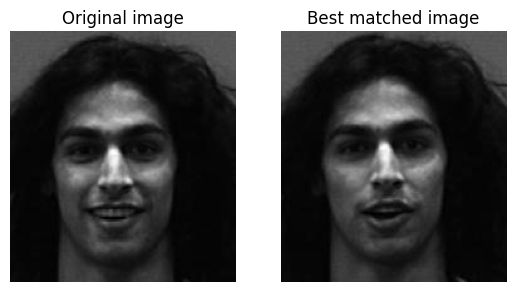

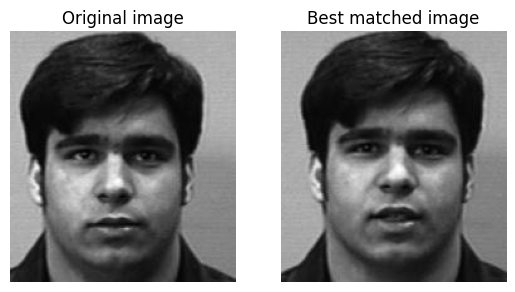

In [10]:
"""- Implement `FacialRec.match()`.
- Generate some random faces with `sample_faces()`, and use `FacialRec.match()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match. """

faces_to_be_matched = FacialRec()

for test_image in sample_faces(5):
    faces_to_be_matched.match(test_image, s=38)
